In [133]:
from dotenv import load_dotenv

load_dotenv()

import aisuite as ai

# Define the client. You can use this variable inside the functions!
CLIENT = ai.Client()


import PyPDF2
import re
import json

import sys
import io
import yfinance as yf
import pandas as pd
from datetime import datetime
import json

In [134]:
# Agent1: Stock Symbol Extractor

def stock_symbol_extractor(company_name: str, model: str = "anthropic:claude-haiku-4-5") -> str: 
    
    ### START CODE HERE ###

    # Define your prompt here. A multi-line f-string is typically used for this.
    prompt = f'''
    
    Give me the stock symbol for the following company name: {company_name}.

    If you cannot find the symbol, respond with "N/A".

    Return only the symbol or "N./A"
    No additional text or any explanation.
    
    ''' 

    ### END CODE HERE ###
    
    # Get a response from the LLM by creating a chat with the client.
    response = CLIENT.chat.completions.create(
        model=model,
        messages=[

            {"role": "system", "content": "You are a smart finance assistant."},
            {"role": "user", "content": prompt}
            ],
        temperature=1.0,
    )

    return response.choices[0].message.content

In [135]:
company_name = "Nvidia"

# Agent 1
symbol = stock_symbol_extractor(company_name)

In [136]:
symbol

'NVDA'

In [137]:
# Tools

def get_current_date():
    """
    Returns the current date as a string.
    """
    return datetime.now().strftime("%Y-%m-%d")

# Download the stock data
def get_stock_data(symbol, start_date, end_date):
    """
    Returns a clean DataFrame with columns:
    Date, Close, High, Open, Volume
    """
    df = yf.download(symbol, start=start_date, end=end_date)

    # Reset index to make 'Date' a column
    df = df.reset_index()

    # If multi-level columns exist (as with yfinance), flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]

    # Standardize column names (handle cases like 'Close_NVDA')
    rename_map = {}
    for col in df.columns:
        for key in ["Date", "Close", "High", "Open", "Volume"]:
            if key.lower() in col.lower():
                rename_map[col] = key
    df = df.rename(columns=rename_map)

    # Keep only required columns, in order
    df = df[["Date", "Close", "High", "Open", "Volume"]]

    return df

current_date = get_current_date()

stock_data = get_stock_data(symbol, '2020-01-01', current_date)


print(stock_data)






/var/folders/jj/0qyq4l9j7rq4gc_0dkxyglpr0000gn/T/ipykernel_20444/3826449281.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

           Date       Close        High        Open     Volume
0    2020-01-02    5.971410    5.971410    5.942537  237536000
1    2020-01-03    5.875832    5.919639    5.851689  205384000
2    2020-01-06    5.900473    5.905700    5.782494  262636000
3    2020-01-07    5.971909    6.017707    5.928849  314856000
4    2020-01-08    5.983108    6.024426    5.967676  277108000
...         ...         ...         ...         ...        ...
1460 2025-10-23  182.160004  183.029999  180.419998  111363700
1461 2025-10-24  186.259995  187.470001  183.839996  131296700
1462 2025-10-27  191.490005  192.000000  189.990005  153452700
1463 2025-10-28  201.029999  203.149994  193.050003  297986200
1464 2025-10-29  207.039993  212.190002  207.979996  308829600

[1465 rows x 5 columns]


In [138]:
tool_def = [
    {
        "type": "function",
        "function": {
            "name": "get_current_date",
            "description": "Returns the current date in YYYY-MM-DD format",
            "parameters": {"type": "object", "properties": {}}
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_stock_data",
            "description": "Fetch stock data for a given symbol and date range.",
            "parameters": {
                "type": "object",
                "properties": {
                    "symbol": {"type": "string"},
                    "start_date": {"type": "string"},
                    "end_date": {"type": "string"}
                },
                "required": ["symbol", "start_date", "end_date"]
            }
        }
    }
]

TOOL_MAPPING = {
    "get_current_date": get_current_date,
    "get_stock_data": get_stock_data,
}

In [139]:
# Agent 2: Get Stock Data

def stock_data_extractor(symbol: str, model: str = "anthropic:claude-haiku-4-5") -> str: 
    
    ### START CODE HERE ###

    # Define your prompt here. A multi-line f-string is typically used for this.
    prompt = f'''

    You have access to two tools:

    get_current_date() to get current date.
    get_stock_data(symbol,start_date,end_date)

    Use the {symbol} as the symbol
    Use '2020-01-01' as the start date.
    Use the current date as the end date.

    Provide me the stock data for the given symbol. 
    
    Use tools when appropriate.

    When you give the final answer, 
    give me the stock data in a pandas DataFrame format as a string.
    Nothing else.
    
    
    
    ''' 

    ### END CODE HERE ###

    max_turns = 3

    messages = [

                {"role": "system", "content": "You are a smart finance and data analyst who is good at executing python functions."},
                {"role": "user", "content": prompt}
                ]

    for i in range(max_turns):

        print(f"Attempt : {i+1}")
    
        # Get a response from the LLM by creating a chat with the client.
        response = CLIENT.chat.completions.create(
            model=model,
            messages=messages,
            tools = tool_def,
            
            temperature=1.0,
        )

        msg = response.choices[0].message
        messages.append(msg)

        # print(msg)

        if not msg.tool_calls:      
            final_text = msg.content
            print("✅ Final answer:")
            print(final_text)
            break

        else:
            print("Tool Calls Detected:")
            print(msg.tool_calls)


        for tool_call in msg.tool_calls:

            tool_id = tool_call.id
            tool_name = tool_call.function.name
            tool_args = tool_call.function.arguments

            args = json.loads(tool_args or "{}")  


            print(f'Calling tool: {tool_name} with args: {tool_args}')

            tool_response = TOOL_MAPPING[tool_name](**args)

            print(f'Tool response: {tool_response}')

            messages.append(
                {
                    "role": "tool",
                    "tool_call_id": tool_id,
                    "tool_name": tool_name,         
                    "content": str(tool_response)    
                }
            )



    return final_text

In [140]:
# Agent 2
stock_data_string = stock_data_extractor(symbol)

Attempt : 1
Tool Calls Detected:
[ChatCompletionMessageToolCall(id='toolu_01NRz6nw47BB2AzvakYo2rqV', function=Function(arguments='{}', name='get_current_date'), type='function')]
Calling tool: get_current_date with args: {}
Tool response: 2025-10-30
Attempt : 2


/var/folders/jj/0qyq4l9j7rq4gc_0dkxyglpr0000gn/T/ipykernel_20444/3826449281.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Tool Calls Detected:
[ChatCompletionMessageToolCall(id='toolu_011nXhtdmfNdcqCZRprrdXYh', function=Function(arguments='{"symbol": "NVDA", "start_date": "2020-01-01", "end_date": "2025-10-30"}', name='get_stock_data'), type='function')]
Calling tool: get_stock_data with args: {"symbol": "NVDA", "start_date": "2020-01-01", "end_date": "2025-10-30"}
Tool response:            Date       Close        High        Open     Volume
0    2020-01-02    5.971410    5.971410    5.942537  237536000
1    2020-01-03    5.875832    5.919639    5.851689  205384000
2    2020-01-06    5.900473    5.905700    5.782494  262636000
3    2020-01-07    5.971909    6.017707    5.928849  314856000
4    2020-01-08    5.983108    6.024426    5.967676  277108000
...         ...         ...         ...         ...        ...
1460 2025-10-23  182.160004  183.029999  180.419998  111363700
1461 2025-10-24  186.259995  187.470001  183.839996  131296700
1462 2025-10-27  191.490005  192.000000  189.990005  153452700
1463 20

✅ Final answer:
```
           Date       Close        High        Open     Volume
0    2020-01-02    5.971410    5.971410    5.942537  237536000
1    2020-01-03    5.875832    5.919639    5.851689  205384000
2    2020-01-06    5.900473    5.905700    5.782494  262636000
3    2020-01-07    5.971909    6.017707    5.928849  314856000
4    2020-01-08    5.983108    6.024426    5.967676  277108000
...         ...         ...         ...        ...        ...
1460 2025-10-23  182.160004  183.029999  180.419998  111363700
1461 2025-10-24  186.259995  187.470001  183.839996  131296700
1462 2025-10-27  191.490005  192.000000  189.990005  153452700
1463 2025-10-28  201.029999  203.149994  193.050003  297986200
1464 2025-10-29  207.039993  212.190002  207.979996  308829600

[1465 rows x 5 columns]
```


In [141]:
stock_data_string

'```\n           Date       Close        High        Open     Volume\n0    2020-01-02    5.971410    5.971410    5.942537  237536000\n1    2020-01-03    5.875832    5.919639    5.851689  205384000\n2    2020-01-06    5.900473    5.905700    5.782494  262636000\n3    2020-01-07    5.971909    6.017707    5.928849  314856000\n4    2020-01-08    5.983108    6.024426    5.967676  277108000\n...         ...         ...         ...        ...        ...\n1460 2025-10-23  182.160004  183.029999  180.419998  111363700\n1461 2025-10-24  186.259995  187.470001  183.839996  131296700\n1462 2025-10-27  191.490005  192.000000  189.990005  153452700\n1463 2025-10-28  201.029999  203.149994  193.050003  297986200\n1464 2025-10-29  207.039993  212.190002  207.979996  308829600\n\n[1465 rows x 5 columns]\n```'

In [142]:
# Step 1: remove the final summary line
cleaned = re.sub(r"\[\d+\s+rows\s+x\s+\d+\s+columns\]", "", stock_data_string).strip()

from io import StringIO
# Step 2: convert to DataFrame using whitespace as delimiter
df = pd.read_csv(StringIO(cleaned), delim_whitespace=True)

/var/folders/jj/0qyq4l9j7rq4gc_0dkxyglpr0000gn/T/ipykernel_20444/2206549366.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(cleaned), delim_whitespace=True)


ParserError: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6


In [143]:
df

,Date,Close,High,Open,Volume
0,2020-01-02,5.971410,5.971410,5.942537,237536000
1,2020-01-03,5.875832,5.919639,5.851689,205384000
2,2020-01-06,5.900473,5.905700,5.782494,262636000
3,2020-01-07,5.971909,6.017707,5.928849,314856000
4,2020-01-08,5.983108,6.024426,5.967676,277108000
...,...,...,...,...,...
1460,2025-10-23,182.160004,183.029999,180.419998,111363700
1461,2025-10-24,186.259995,187.470001,183.839996,131296700
1462,2025-10-27,191.490005,192.000000,189.990005,153452700
1463,2025-10-28,201.029999,203.149994,193.050003,297986200


In [144]:
stock_data_string=df
stock_data_string

,Date,Close,High,Open,Volume
0,2020-01-02,5.971410,5.971410,5.942537,237536000
1,2020-01-03,5.875832,5.919639,5.851689,205384000
2,2020-01-06,5.900473,5.905700,5.782494,262636000
3,2020-01-07,5.971909,6.017707,5.928849,314856000
4,2020-01-08,5.983108,6.024426,5.967676,277108000
...,...,...,...,...,...
1460,2025-10-23,182.160004,183.029999,180.419998,111363700
1461,2025-10-24,186.259995,187.470001,183.839996,131296700
1462,2025-10-27,191.490005,192.000000,189.990005,153452700
1463,2025-10-28,201.029999,203.149994,193.050003,297986200


In [145]:
type(stock_data_string)

pandas.core.frame.DataFrame

In [146]:
# Agent 3: Visualizing the code

def visualize_data(company_name: str, stock_data_string: str, model: str = "anthropic:claude-haiku-4-5") -> str: 
    
    ### START CODE HERE ###

    # Define your prompt here. A multi-line f-string is typically used for this.
    prompt = f'''
    
    I have the stock data for the company: {company_name}.

    The data is in the for a DataFrame as a string: {stock_data_string}

    The name of the dataFrame is "stock_data_string"

    I need a python code to visualize this.
    You already know the dataFrame variable name and it's structure.
    I need to use all the data entries.
    Using that, generate me a python code

    The code should generate a multi-line plot for:
    - Date vs Close Price
    - Date vs Open Price
    - Date vs High Price
    - Date vs Low Price

    Make sure, you convert the price values from str to int or float just to be safe.
    


    Give me the resultant python code in this format only.

    <executeable_python>
    # code
    <executeable_python>
   
    
    ''' 

    ### END CODE HERE ###
    
    # Get a response from the LLM by creating a chat with the client.
    response = CLIENT.chat.completions.create(
        model=model,
        messages=[

            {"role": "system", "content": "You are a python programming expert."},
            {"role": "user", "content": prompt}
            ],
        temperature=1.0,
    )

    return response.choices[0].message.content

In [147]:
# Agent 3
python_code = visualize_data(company_name, stock_data_string)

In [148]:
python_code

"<executeable_python>\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Convert Date column to datetime\nstock_data_string['Date'] = pd.to_datetime(stock_data_string['Date'])\n\n# Convert price columns to float to ensure numeric type\nstock_data_string['Close'] = stock_data_string['Close'].astype(float)\nstock_data_string['Open'] = stock_data_string['Open'].astype(float)\nstock_data_string['High'] = stock_data_string['High'].astype(float)\n\n# Create figure and axis\nplt.figure(figsize=(14, 7))\n\n# Plot all price lines\nplt.plot(stock_data_string['Date'], stock_data_string['Close'], label='Close Price', linewidth=2)\nplt.plot(stock_data_string['Date'], stock_data_string['Open'], label='Open Price', linewidth=2)\nplt.plot(stock_data_string['Date'], stock_data_string['High'], label='High Price', linewidth=2)\n\n# Labels and title\nplt.xlabel('Date', fontsize=12)\nplt.ylabel('Price ($)', fontsize=12)\nplt.title('Nvidia Stock Price - Close, Open, and High Prices Over Time', fonts

In [149]:
code = python_code.replace("<executeable_python>", "").replace("</executeable_python>", "").strip()
code

"import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Convert Date column to datetime\nstock_data_string['Date'] = pd.to_datetime(stock_data_string['Date'])\n\n# Convert price columns to float to ensure numeric type\nstock_data_string['Close'] = stock_data_string['Close'].astype(float)\nstock_data_string['Open'] = stock_data_string['Open'].astype(float)\nstock_data_string['High'] = stock_data_string['High'].astype(float)\n\n# Create figure and axis\nplt.figure(figsize=(14, 7))\n\n# Plot all price lines\nplt.plot(stock_data_string['Date'], stock_data_string['Close'], label='Close Price', linewidth=2)\nplt.plot(stock_data_string['Date'], stock_data_string['Open'], label='Open Price', linewidth=2)\nplt.plot(stock_data_string['Date'], stock_data_string['High'], label='High Price', linewidth=2)\n\n# Labels and title\nplt.xlabel('Date', fontsize=12)\nplt.ylabel('Price ($)', fontsize=12)\nplt.title('Nvidia Stock Price - Close, Open, and High Prices Over Time', fontsize=14, fontweight='bo

In [151]:
# Agent 4: Refining the code

def refine_code(code: str, model: str = "anthropic:claude-haiku-4-5") -> str: 
    
    ### START CODE HERE ###

    # Define your prompt here. A multi-line f-string is typically used for this.
    prompt = f'''
    
    Refine the following python code to ensure it runs without any errors.

    Here is the code:

    {code}
    


    Give me the resultant python code in this format only.

    <executeable_python>
    # code
    <executeable_python>
   
    
    ''' 

    ### END CODE HERE ###
    
    # Get a response from the LLM by creating a chat with the client.
    response = CLIENT.chat.completions.create(
        model=model,
        messages=[

            {"role": "system", "content": "You are an expert at python programming, debugging and troubleshooting and refining codes."},
            {"role": "user", "content": prompt}
            ],
        temperature=1.0,
    )

    return response.choices[0].message.content

In [152]:
# Agent 4
python_code2 = refine_code(code)

In [153]:
code = python_code2.replace("<executeable_python>", "").replace("</executeable_python>", "").strip()
code

"import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Sample data creation (since stock_data_string is not defined)\n# Replace this with your actual data loading\nstock_data_string = pd.DataFrame({\n    'Date': ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05'],\n    'Close': ['150.25', '151.30', '149.80', '152.15', '153.45'],\n    'Open': ['149.50', '150.10', '150.95', '149.25', '151.80'],\n    'High': ['152.00', '152.75', '151.50', '153.20', '154.60']\n})\n\n# Convert Date column to datetime\nstock_data_string['Date'] = pd.to_datetime(stock_data_string['Date'])\n\n# Convert price columns to float to ensure numeric type\nstock_data_string['Close'] = pd.to_numeric(stock_data_string['Close'], errors='coerce')\nstock_data_string['Open'] = pd.to_numeric(stock_data_string['Open'], errors='coerce')\nstock_data_string['High'] = pd.to_numeric(stock_data_string['High'], errors='coerce')\n\n# Remove any rows with NaN values\nstock_data_string = stock_data_string.dropna(

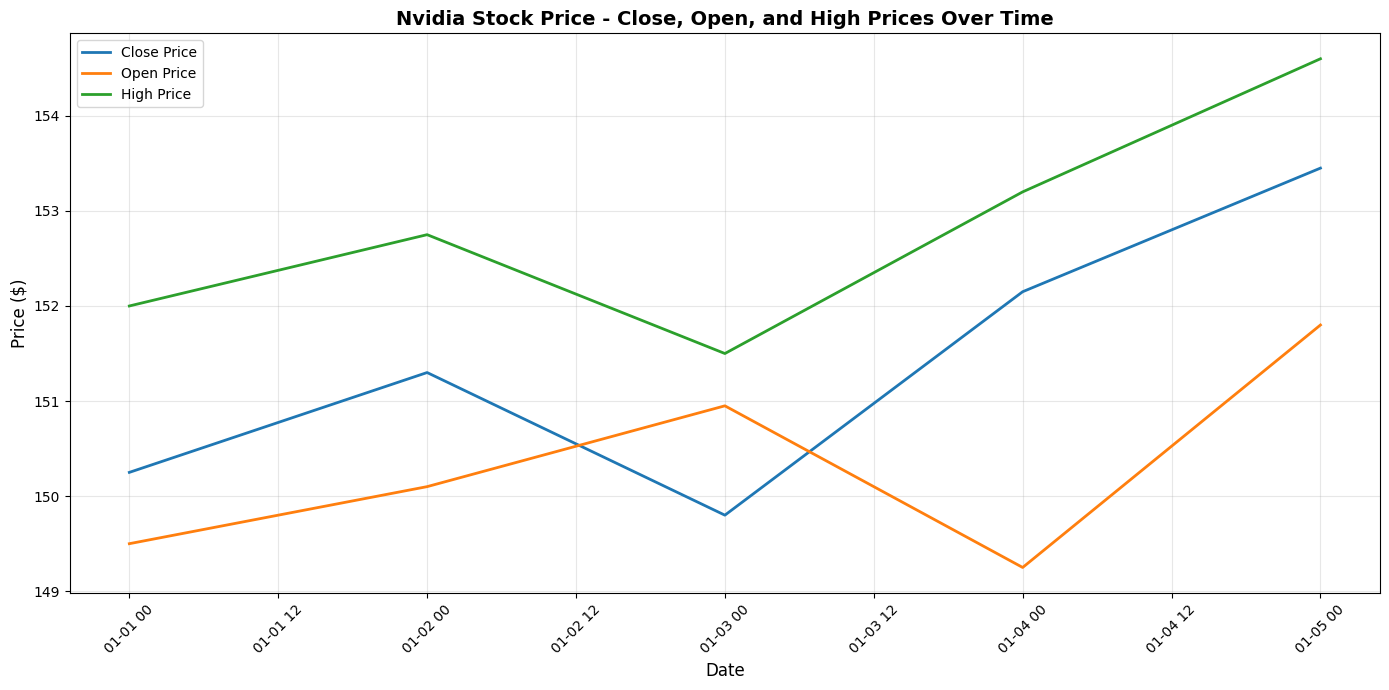

In [154]:
exec(code)

In [160]:
# Agent 5: Refining the code again

def refine_advanced_code(code: str, stock_data_string, model: str = "anthropic:claude-haiku-4-5") -> str: 
    
    ### START CODE HERE ###

    # Define your prompt here. A multi-line f-string is typically used for this.
    prompt = f'''
    
    Refine the following python code for it's advanced correctness and the visualization.
    Assess the charts, the values, the dates, the colour co-ordination and everything.

    Here is the code:

    {code}

    Here is the dataFrame:

    {stock_data_string}
    


    Give me the resultant python code in this format only. No other explanations or anything.
    Give in this format only.

    <executeable_python>
    # code
    <executeable_python>
   
    
    ''' 

    ### END CODE HERE ###
    
    # Get a response from the LLM by creating a chat with the client.
    response = CLIENT.chat.completions.create(
        model=model,
        messages=[

            {"role": "system", "content": "You are an expert at python programming, debugging and troubleshooting and refining codes."},
            {"role": "user", "content": prompt}
            ],
        temperature=1.0,
    )

    return response.choices[0].message.content

In [161]:
# Agent 5
python_code5 = refine_advanced_code(code, stock_data_string)

In [166]:
python_code5

'```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nfrom matplotlib.ticker import FuncFormatter\n\n# Sample data creation\nstock_data_string = pd.DataFrame({\n    \'Date\': [\'2024-01-01\', \'2024-01-02\', \'2024-01-03\', \'2024-01-04\', \'2024-01-05\'],\n    \'Close\': [\'150.25\', \'151.30\', \'149.80\', \'152.15\', \'153.45\'],\n    \'Open\': [\'149.50\', \'150.10\', \'150.95\', \'149.25\', \'151.80\'],\n    \'High\': [\'152.00\', \'152.75\', \'151.50\', \'153.20\', \'154.60\']\n})\n\n# Convert Date column to datetime\nstock_data_string[\'Date\'] = pd.to_datetime(stock_data_string[\'Date\'])\n\n# Convert price columns to float to ensure numeric type\nstock_data_string[\'Close\'] = pd.to_numeric(stock_data_string[\'Close\'], errors=\'coerce\')\nstock_data_string[\'Open\'] = pd.to_numeric(stock_data_string[\'Open\'], errors=\'coerce\')\nstock_data_string[\'High\'] = pd.to_numeric(stock_data_string[\'High\'], errors=\'coerce\')\n\n# Remo

In [167]:
code = python_code5.replace("```python", "").replace("```", "").strip()
code

'import pandas as pd\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nfrom matplotlib.ticker import FuncFormatter\n\n# Sample data creation\nstock_data_string = pd.DataFrame({\n    \'Date\': [\'2024-01-01\', \'2024-01-02\', \'2024-01-03\', \'2024-01-04\', \'2024-01-05\'],\n    \'Close\': [\'150.25\', \'151.30\', \'149.80\', \'152.15\', \'153.45\'],\n    \'Open\': [\'149.50\', \'150.10\', \'150.95\', \'149.25\', \'151.80\'],\n    \'High\': [\'152.00\', \'152.75\', \'151.50\', \'153.20\', \'154.60\']\n})\n\n# Convert Date column to datetime\nstock_data_string[\'Date\'] = pd.to_datetime(stock_data_string[\'Date\'])\n\n# Convert price columns to float to ensure numeric type\nstock_data_string[\'Close\'] = pd.to_numeric(stock_data_string[\'Close\'], errors=\'coerce\')\nstock_data_string[\'Open\'] = pd.to_numeric(stock_data_string[\'Open\'], errors=\'coerce\')\nstock_data_string[\'High\'] = pd.to_numeric(stock_data_string[\'High\'], errors=\'coerce\')\n\n# Remove any rows

In [168]:
code = code.replace("<executeable_python>", "").replace("</executeable_python>", "").strip()
code

'import pandas as pd\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nfrom matplotlib.ticker import FuncFormatter\n\n# Sample data creation\nstock_data_string = pd.DataFrame({\n    \'Date\': [\'2024-01-01\', \'2024-01-02\', \'2024-01-03\', \'2024-01-04\', \'2024-01-05\'],\n    \'Close\': [\'150.25\', \'151.30\', \'149.80\', \'152.15\', \'153.45\'],\n    \'Open\': [\'149.50\', \'150.10\', \'150.95\', \'149.25\', \'151.80\'],\n    \'High\': [\'152.00\', \'152.75\', \'151.50\', \'153.20\', \'154.60\']\n})\n\n# Convert Date column to datetime\nstock_data_string[\'Date\'] = pd.to_datetime(stock_data_string[\'Date\'])\n\n# Convert price columns to float to ensure numeric type\nstock_data_string[\'Close\'] = pd.to_numeric(stock_data_string[\'Close\'], errors=\'coerce\')\nstock_data_string[\'Open\'] = pd.to_numeric(stock_data_string[\'Open\'], errors=\'coerce\')\nstock_data_string[\'High\'] = pd.to_numeric(stock_data_string[\'High\'], errors=\'coerce\')\n\n# Remove any rows

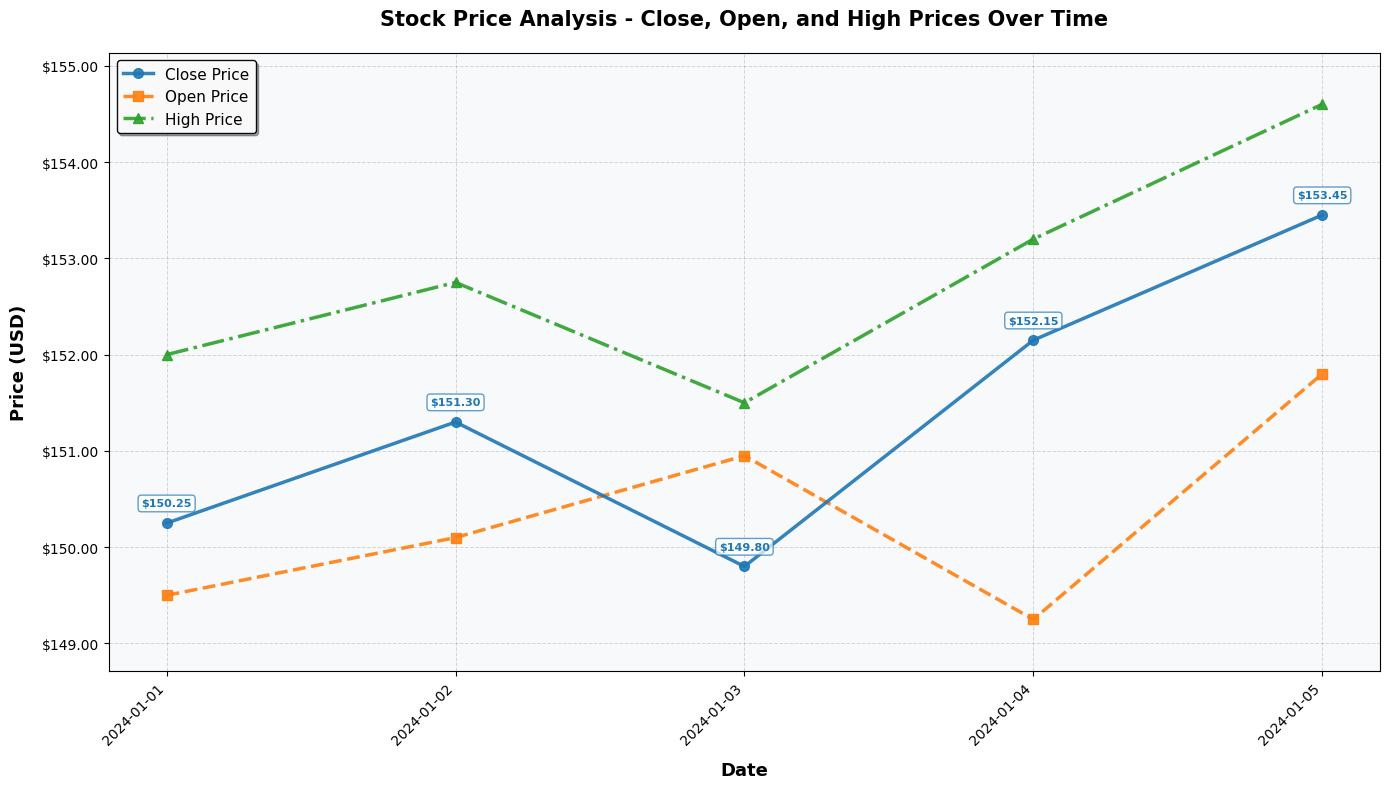


              STOCK PRICE ANALYSIS - SUMMARY STATISTICS               

Date Range: 2024-01-01 to 2024-01-05
Total Trading Days: 5

Close Price.............. Open Price............... High Price...............
----------------------------------------------------------------------
Min: $149.80              Min: $149.25              Min: $151.50             
Max: $153.45              Max: $151.80              Max: $154.60             
Mean: $151.39             Mean: $150.32             Mean: $152.81            
Std Dev: $1.47            Std Dev: $1.06            Std Dev: $1.20           

                 Daily Price Changes (Close to Close)                 
2024-01-02: ↑ $+1.05 (+0.70%)
2024-01-03: ↓ $-1.50 (-0.99%)
2024-01-04: ↑ $+2.35 (+1.57%)
2024-01-05: ↑ $+1.30 (+0.85%)



In [169]:
exec(code)